<div class="frontmatter text-center">
<h1>DNDS 5014: Research Seminar</h1>
<h2>Midterm Assignment</h2>
<h3>Central European University, Fall 2024</h3>
<h3>Instructor: Prof. Federico Battiston, TA: Onkar Sadekar</h3>
<h4> Deadline: 8th November 2024, Friday, 23:59 </h4>

</div>

## Overview

In this notebook you will find the exercises for the first half of the course.

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
import geopy.distance

## Download the dataset from here:
https://snap.stanford.edu/data/loc-brightkite.html


## Load the dataset
Load the dataset `loc-brightkite_totalCheckins.txt.gz` into a pandas dataframe as follows with the following columns. 

df = pd.read_csv('loc-brightkite_totalCheckins.txt.gz', sep='\t', 
                names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])


In [3]:
df = pd.read_csv('loc-brightkite_totalCheckins.txt.gz', sep='\t', 
                names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])

1) Plot the distribution of number of checkins for each user.<br>
Qualitatively explain what distribution it follows. Explain any interesting findings and possible reasons for the same.


We can get the number of check-ins per user by grouping the instances by user, in many possible ways:

In [4]:
user_checkins = df['user'].groupby(df['user']).count() #or df.value_counts(subset=['user']), or df['user'].value_counts()
user_checkins[:10]

user
0    2100
1    1210
2    2100
3    1807
4     779
5     407
6     801
7    1621
8      33
9     112
Name: user, dtype: int64

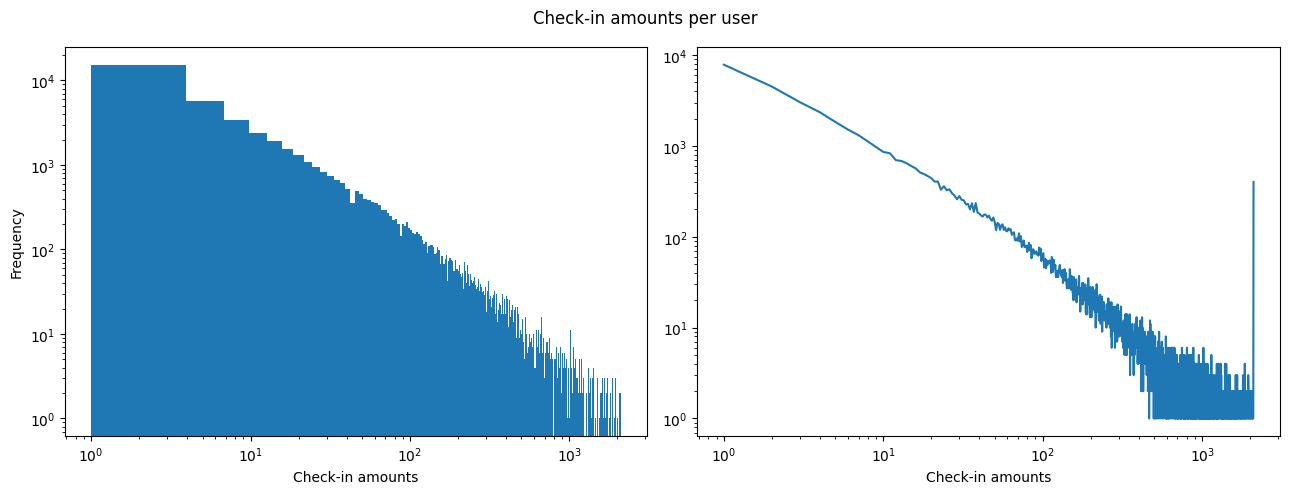

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

#Try back-and-forth number of bins
axes[0].hist(user_checkins, bins=int(len(np.unique(user_checkins))/2), log=True) #half the number of unique values is a lot, but not too much such that quantization makes too much difference
axes[0].set_xscale('log')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Check-in amounts')

checkins_unique, counts = np.unique(user_checkins, return_counts=True)
axes[1].plot(checkins_unique, counts)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Check-in amounts')

fig.suptitle('Check-in amounts per user')
plt.tight_layout()
plt.show()

The distribution seems to be a power-law distribution, with an exponent $-\alpha$ of roughly -1 (the counts decreased to 1/10th between $10^1$ and $10^2$).

The maximal value (exactly 2100) is unrealistically overrepresented from the plot, which hints at an data collection related issue: any user with more than 2100 (maximum value) check-ins likely to have been capped at 2100. It's better to not plot this value on the distribution.

## 2)
**Find the number of checkins for each unique location.**<br>
**Remove the locations with more than 100k checkins and plot the distribution of the number of checkins at a location.<br>**
**Use the powerlaw package to find the best value of alpha for the powerlaw distribution.<br>**
**Qualitatively explain your findings and the possible reasons for all your observations.**

I noticed a cases where the location id is 0, latitude and longitude are 0 - i.e. the information is missing.<br>
We do not need these instances for this analysis, nor for task 3, so I remove them: 

In [6]:
df = df[df['location id'].notna() & (df['location id'] != "00000000000000000000000000000000")]

Calculating best minimal value for power law fit


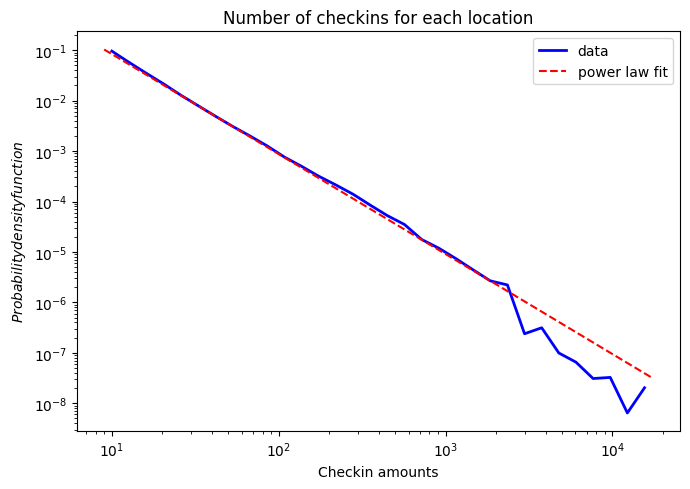

In [7]:
location_checkin = df.value_counts(subset=['location id'])
location_checkin = location_checkin[location_checkin<=100000]

data = np.asarray(location_checkin)
fit = powerlaw.Fit(data, discrete=True)

fig, ax = plt.subplots(1,1, figsize=(7,5))
fit.plot_pdf(color='b', linewidth=2,label='data')
fit.power_law.plot_pdf(color='red', linestyle='--', ax=ax, label='power law fit')
ax.set_ylabel(r'$Probability density function$')
ax.set_xlabel(r'Checkin amounts')
ax.set_title('Number of checkins for each location')

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
fit.alpha, fit.xmin, fit.xmax, fit.D 

(1.9830884408696883, 9.0, None, 0.00649689510287732)

The fit resulted in a very low Kolmogorov-Smirnov distance (indicating that the underlying data structure is indeed power-law), so we can assume that just like the distribution of checkin counts per user, the checkin counts per locations are also power-law distributed. This could stem from the fact that cities' population are also power-law distributed (and I guess that city sizes have a power-law distribution) and checkins may be proportional to population size, city size, or simply can stem from preferential-attachment-like phenomenons. 

The $\alpha$ value is ~2, meaning even the theoretical distribution's mean is infinite, not just the variance.

The fit is constructed with infinite maximal value (`xmax` is None), but from the plot we can see that after roughly 2000 the distribtuiton differs from the fit greatly. The highest checkin amounts deviates from a power-law distribution (otherwise they'd fit represent a line on our log-log plot), and they are below the line, i.e. more rare than expected by the fit.<br>
If we do not remove the high values, the tail will be quite "discrete"/nonlinear (it is discrete in general, what I mean is the amounts become more rare and deviations increase relatively, thus data is more noisy and the distribution is less "smooth"). We can try removing it, out of curiosity:

Calculating best minimal value for power law fit


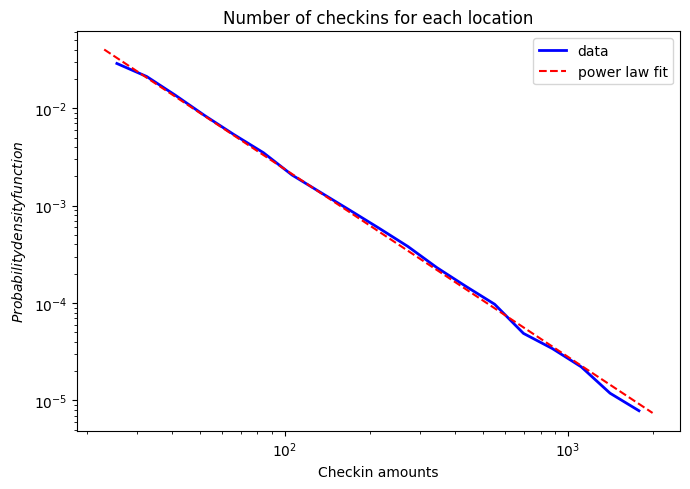

(1.926353237793943, 23.0, 2000.0, 0.004552844274854251)

In [9]:
fit2 = powerlaw.Fit(data, discrete=True, xmax=2000)

fig, ax = plt.subplots(1,1, figsize=(7,5))
fit2.plot_pdf(color='b', linewidth=2,label='data')
fit2.power_law.plot_pdf(color='red', linestyle='--', ax=ax, label='power law fit')
ax.set_ylabel(r'$Probability density function$')
ax.set_xlabel(r'Checkin amounts')
ax.set_title('Number of checkins for each location')

plt.legend()
plt.tight_layout()
plt.show()

fit2.alpha, fit2.xmin, fit2.xmax, fit2.D

That looks better, and in fact, the $\alpha$ value decreased, which makes sense: the excluded values below the line dragged the fit "down", having a steeper slope, and thus a faster decrease of probabilites (e.g. in the tail), meaning a higher $\alpha$ value. The most probable values of the distribution hence fit a lower $\alpha$ value fit better.

## 3)
**Consider 5000 random users in the dataset. Find the center of mass of the locations that they have checked into.**<br>
**Using the center of mass, calculate the radius of gyration of these users and plot the distribution for the same.**<br>
**Qualitatively explain your findings and the possible reasons for all your observations.**

The easiest way to calculate these is to just first convert every point into Cartesian coordinates (e.g. add x, y, z as 3 columns) and then work with Cartesian coordinates - in the end we only need a radius, not positions so we can just abandon spherical coordinates and work with the easier Cartesians.<br>

In [ ]:
def spherical_to_cartesian(lats, lons):
    R = 6371  #Earth radius

    lats_rad = np.radians(lats)
    lons_rad = np.radians(lons)
    xs = R * np.cos(lats_rad) * np.cos(lons_rad)
    ys = R * np.cos(lats_rad) * np.sin(lons_rad)
    zs = R * np.sin(lats_rad)
    
    return xs, ys, zs

def center_of_mass(weights, xs, ys, zs):
    return np.sum(weights*xs)/np.sum(weights), np.sum(weights*ys)/np.sum(weights), np.sum(weights*zs)/np.sum(weights)

def radius_of_gyration(weights, xs, ys, zs): #Formula from PPT
    x_cm, y_cm, z_cm = center_of_mass(weights, xs, ys, zs)
    return np.sqrt(np.sum(weights*((xs-x_cm)**2 + (ys-y_cm)**2 + (zs-z_cm)**2))/np.sum(weights))

In [ ]:
np.random.seed(20001104)
#select 5000 different users (set of unique user values)
users = np.random.choice(df['user'].unique(), 5000, replace=False)
df_sample = df[df['user'].isin(users)].copy()
rgs = []
for user in users:
    user_checkins = df_sample[df_sample['user'] == user]
    latitudes = user_checkins['latitude'].values
    longitudes = user_checkins['longitude'].values
    xs, ys, zs = spherical_to_cartesian(latitudes, longitudes)
    
    x_cm, y_cm, z_cm = center_of_mass([1]*len(xs), xs, ys, zs)
    r_g = radius_of_gyration([1]*len(xs), xs, ys, zs)
    df_sample.loc[df_sample['user'] == user, 'user_x_cm'] = x_cm #unneccessary, but good for checking values conveniently
    df_sample.loc[df_sample['user'] == user, 'user_y_cm'] = y_cm
    df_sample.loc[df_sample['user'] == user, 'user_z_cm'] = z_cm
    df_sample.loc[df_sample['user'] == user, 'user_r_g'] = r_g
    rgs.append(r_g)

Put the values back to the table (*quite redundant*) just for checking them out nicely:

In [94]:
df_sample[:10000:1000]

,user,check-in_time,latitude,longitude,location id,user_x_cm,user_y_cm,user_z_cm,user_r_g
5410,3,2010-10-17T11:44:21Z,38.945110,-77.451706,200dced1036e9b5cd93511d5eb14f2f7,-2262.541087,-4330.457751,3890.614245,1257.300797
6420,3,2010-05-16T00:49:35Z,37.740104,-122.438231,e0d90ce08dd211dd9d9e003048c0801e,-2262.541087,-4330.457751,3890.614245,1257.300797
17188,15,2010-02-13T18:03:57Z,40.723940,-73.997984,848e8be8d467e2bcde747940ced489a3,-940.927354,-4780.098478,3971.343317,1040.859027
18189,15,2009-05-13T02:24:05Z,40.017315,-105.282779,0d657ad796a35f6dac7a0e017854bd8a02657721,-940.927354,-4780.098478,3971.343317,1040.859027
26642,23,2010-07-29T05:20:43Z,37.788977,-122.408567,198c2c75d3f536c00583d01c7278fe4575640f5c,-2343.392927,-4134.090244,3941.850147,1571.389787
27642,23,2009-07-15T20:10:15Z,37.485215,-122.236355,ee8064eaa22411dda6a473b5c7bcff4f,-2343.392927,-4134.090244,3941.850147,1571.389787
28642,24,2008-06-01T00:43:17Z,40.044001,-105.256712,c09617edc7ff700faf66ec71a7646b2506e20035,-1796.991084,-4454.618789,3986.133733,1275.763828
67799,80,2008-08-14T02:10:14Z,40.017842,-105.281716,6d042c91a6c6206aec5602659ecb9877b4b9ce13,-956.060393,-4487.212487,4126.155289,1585.987436
74071,108,2008-11-11T05:39:16Z,34.416214,-119.703903,7cd2366eafaa11ddad7c003048c10834,730.989655,-4604.442655,4050.961000,1563.367499
98687,160,2008-12-29T06:27:26Z,3.618274,72.776184,dbf6e1f42c4d77b75ff76cbf15b1e34a4b7acb7f,1827.932581,6067.609875,421.317082,504.881971


There are users who visit the same location everytime, so their radius of gyration is 0. We need to exclude those from the plot (cannot plot 0 on log scale). As floating point calculations have imperfections, we need to also check the very close to 0 values, not just 0.

In [95]:
df_sample[df_sample['user_r_g']>0].sort_values(by='user_r_g', ascending=True)[:4]

,user,check-in_time,latitude,longitude,location id,user_x_cm,user_y_cm,user_z_cm,user_r_g
4544389,45127,2009-06-25T20:51:42Z,51.517224,-0.20583,99996b2c61c111de8608003048c0801e,3964.516121,-14.242233,4987.188595,1.776357e-15
4544385,45127,2009-06-30T21:37:21Z,51.517224,-0.20583,99996b2c61c111de8608003048c0801e,3964.516121,-14.242233,4987.188595,1.776357e-15
4544386,45127,2009-06-27T16:58:03Z,51.517224,-0.20583,99996b2c61c111de8608003048c0801e,3964.516121,-14.242233,4987.188595,1.776357e-15
4544387,45127,2009-06-26T08:38:19Z,51.517224,-0.20583,99996b2c61c111de8608003048c0801e,3964.516121,-14.242233,4987.188595,1.776357e-15


Let's just check what seems to be the "calculation error" -- "actual minimum value" line, to threshold the values

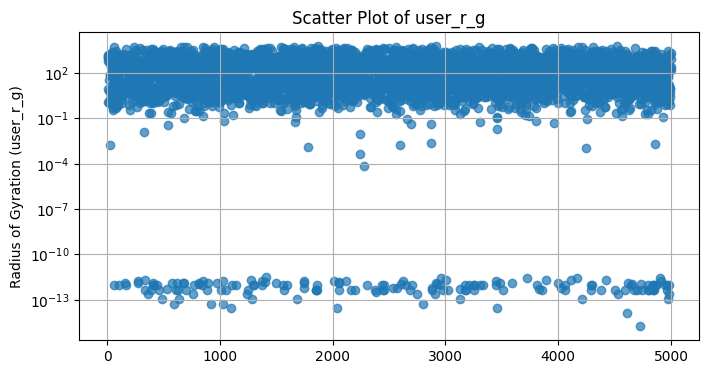

In [96]:
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(len(rgs)), rgs, alpha=0.7,)
plt.ylabel('Radius of Gyration (user_r_g)')
plt.title('Scatter Plot of user_r_g')

plt.yscale('log')
plt.grid(True)
plt.show()

Seems 10^-5 is a feasible threshold. Let's filter, and plot a histogram:

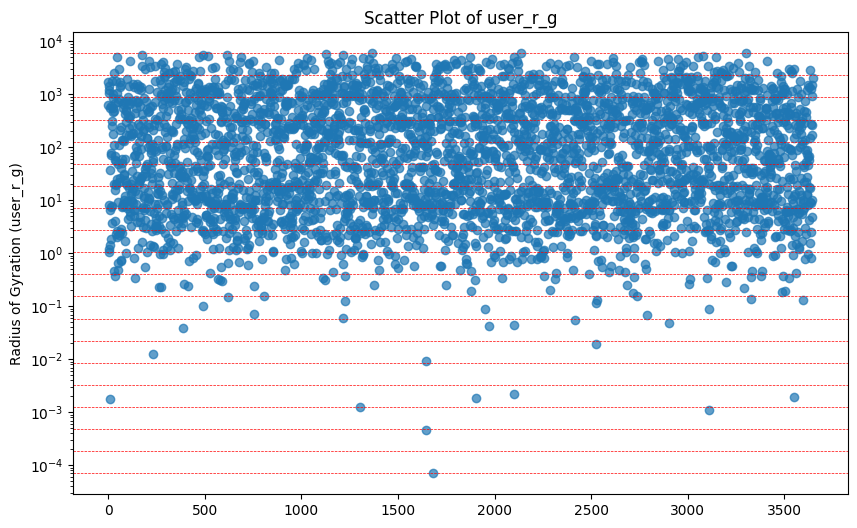

In [97]:
rgs = np.array(rgs)
rgs = rgs[rgs>0.00001]
bin_edges = np.logspace(np.log10(rgs.min()), np.log10(rgs.max()), num=20)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(rgs)), rgs, alpha=0.7,)
plt.ylabel('Radius of Gyration (user_r_g)')
plt.title('Scatter Plot of user_r_g')

for bin in bin_edges:
    plt.axhline(y=bin, color='r', linestyle='--', linewidth=0.5)

plt.yscale('log')
plt.show()

In [98]:
rgs.size, rgs[rgs<0.0001].size, rgs[rgs<0.001].size, rgs[rgs<0.01].size, rgs[rgs<0.1].size, rgs[rgs<1].size

(3647, 1, 2, 9, 21, 152)

We now only have ~ 3600 users from the 5000, not that much.

There are also few users with < 1 kilometer radius of gyration, e.g. who checked in at places "on average" ~10 or ~100 metres away. This intuitively makes sense, why would you check in again after 50 metres? We might have to exclude these too.

Let's plot the distribution:

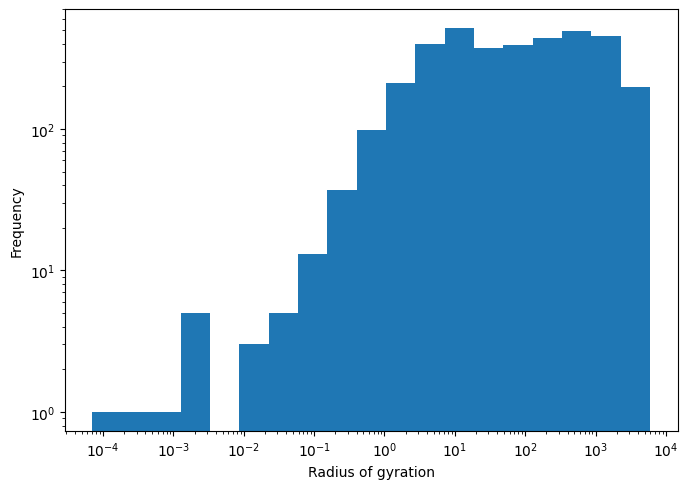

In [99]:
fig, axes = plt.subplots(1,1, figsize=(7,5))
axes.hist(rgs, bins=bin_edges, log=True)
axes.set_xscale('log')
axes.set_ylabel('Frequency')
axes.set_xlabel('Radius of gyration')
plt.tight_layout()
plt.show()

In [100]:
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
np.histogram(rgs, bins=bin_edges)

(array([  1,   1,   1,   5,   0,   3,   5,  13,  37,  98, 213, 401, 516,
        372, 392, 440, 496, 456, 197], dtype=int64),
 array([7.06336017e-05, 1.84606545e-04, 4.82483913e-04, 1.26101015e-03,
        3.29575048e-03, 8.61370643e-03, 2.25126080e-02, 5.88384945e-02,
        1.53779093e-01, 4.01913910e-01, 1.05043402e+00, 2.74539301e+00,
        7.17530334e+00, 1.87532269e+01, 4.90130526e+01, 1.28099518e+02,
        3.34798295e+02, 8.75022016e+02, 2.28693975e+03, 5.97709923e+03]))

There seem to be no values between ~$2*10^{-3}$ and ~$10^{-2}$. That at first seems strange, but we already discussed that there are very few users with a radius of gyration less than 1 km, and with this bin count, the bin edges just happened to leave a "gap" between the values. A bit playing around with the bins can change that.

At first, we do not see marks of a power-law distribution. Let's check the lineplot (without any bin density modifications).

### No density normalization of bins

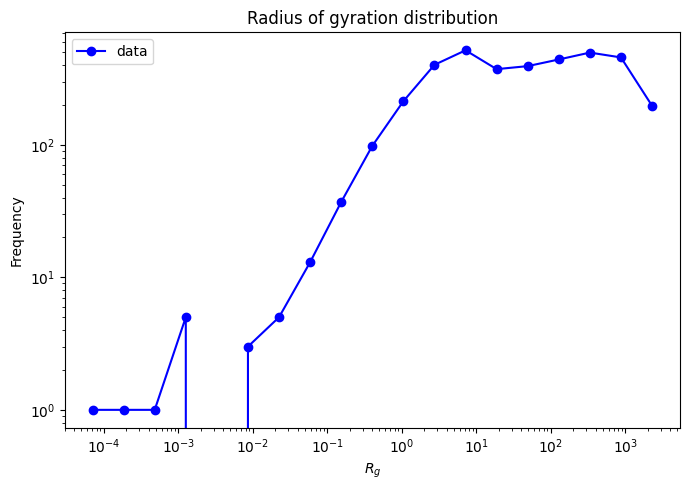

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
counts, _ = np.histogram(rgs, bins=bin_edges)

plt.loglog(bin_edges[:-1], counts, marker='o', linestyle=None,  color='blue',label='data')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$R_g$')

ax.set_title('Radius of gyration distribution')

plt.legend()
plt.tight_layout()
plt.show()

There is some power-law like growth between $10^{-2}$ and $10^1$, with a positive exponent, otherwise the distribution is not scale-free.<br>

Can't fit a model on the relevant section as we cannot have positive exponents (PDF wouldn't exist), but we can calculate roughly the steepness: 

In [ ]:
limits =(6,13)
lengths = bin_edges[1:] - bin_edges[:-1]

log_counts = np.log10(counts)
log_lengths = np.log10(lengths)

steeps = (log_counts[1:] - log_counts[:-1]) / (log_lengths[1:] - log_lengths[:-1])
steeps[limits[0]:limits[1]-2]

array([0.99457766, 1.08873312, 1.01387371, 0.80806483, 0.65853603])

Eyeballed an exponent of 1 from the lines and this seems to somewhat hold.

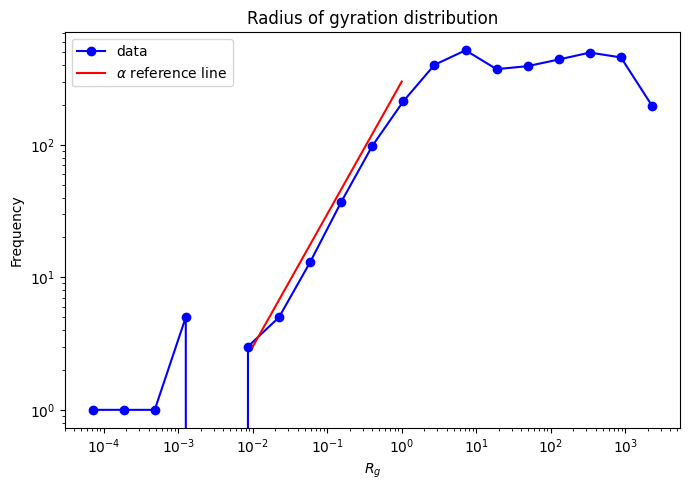

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
counts, _ = np.histogram(rgs, bins=bin_edges)

plt.loglog(bin_edges[:-1], counts, marker='o', linestyle=None,  color='blue',label='data')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$R_g$')

ax.set_title('Radius of gyration distribution')
x_line = np.logspace(np.log10(0.01), np.log10(1), num=100)
y_line = np.logspace(np.log10(3), np.log10(300), num=100)
plt.plot(x_line, y_line, color='red', linestyle='-', label=r'$\alpha=1$ reference line')

plt.legend()
plt.tight_layout()
plt.show()

## Normalized bins (density=True)

In [124]:
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
np.histogram(rgs, bins=bin_edges, density=True)

(array([2.40581635e+00, 9.20506223e-01, 3.52201326e-01, 6.73791065e-01,
        0.00000000e+00, 5.91840952e-02, 3.77414011e-02, 3.75453039e-02,
        4.08863417e-02, 4.14349541e-02, 3.44575700e-02, 2.48206799e-02,
        1.22203392e-02, 3.37086031e-03, 1.35908976e-03, 5.83685636e-04,
        2.51751614e-04, 8.85563456e-05, 1.46381208e-05]),
 array([7.06336017e-05, 1.84606545e-04, 4.82483913e-04, 1.26101015e-03,
        3.29575048e-03, 8.61370643e-03, 2.25126080e-02, 5.88384945e-02,
        1.53779093e-01, 4.01913910e-01, 1.05043402e+00, 2.74539301e+00,
        7.17530334e+00, 1.87532269e+01, 4.90130526e+01, 1.28099518e+02,
        3.34798295e+02, 8.75022016e+02, 2.28693975e+03, 5.97709923e+03]))

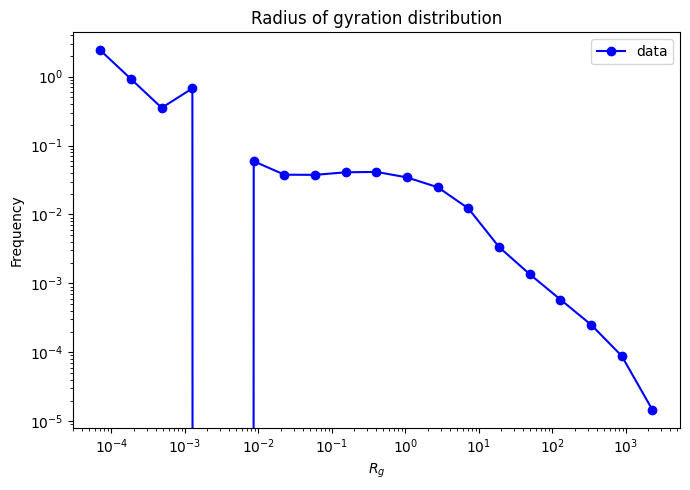

In [125]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
density, _ = np.histogram(rgs, bins=bin_edges, density=True)

plt.loglog(bin_edges[:-1], density, marker='o', linestyle=None,  color='blue',label='data')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$R_g$')

ax.set_title('Radius of gyration distribution')

plt.legend()
plt.tight_layout()
plt.show()

We see surprisingly the probabilities be very high for small radiuses, more about that down below. But we know that the first 3 bins (dots) only represent 1 instance, the 4th represents 5, and the 0 values between 0.002 and 0.01 are due to not having any instances in that bin (0 multiplied by any number is 0).<br>
If we change the binsize (and hence bin edges), we can get each bin have at least 1 instance:

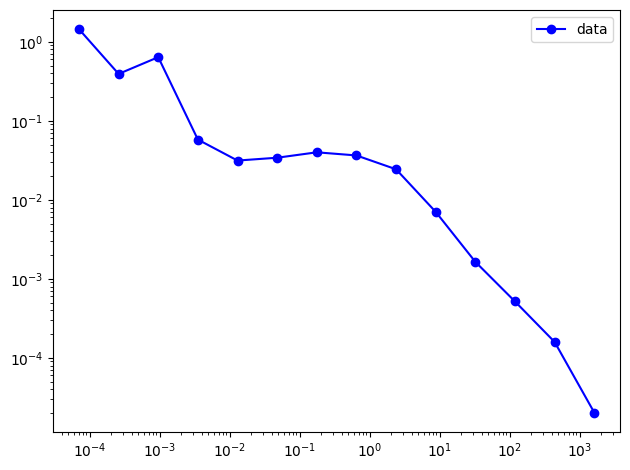

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=15)
density, _ = np.histogram(rgs, bins=bin_edges, density=True)

plt.loglog(bin_edges[:-1], density, marker='o', linestyle=None,  color='blue',label='data')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$R_g$')

ax.set_title('Radius of gyration distribution')

plt.legend()
plt.tight_layout()
plt.show()

But how come the small radius of gyrations have so high probability, meanwhile the first bins have only 1 instance?

Well, the answer is the density normalization. The bin height (probability) isn't anymore a count of instances, but is divided by the bin width, and since we have so small bin widths these values grow very high in comparison to the other bins.


<br> This might come as a surprise, and we think we are mislead - but we have to interpret this correctly: in the range of small values, choosing a constant width interval (constant in the sense that we pick an interval length and "slide" it through the x values, like a sliding window, checking for which windows have the most instances), the number of occurrences will be highest among the small $r_g$ values (if the window length is small enough), according to the PDF. We could be assured of that if we plot the occurrences on a linear scale:

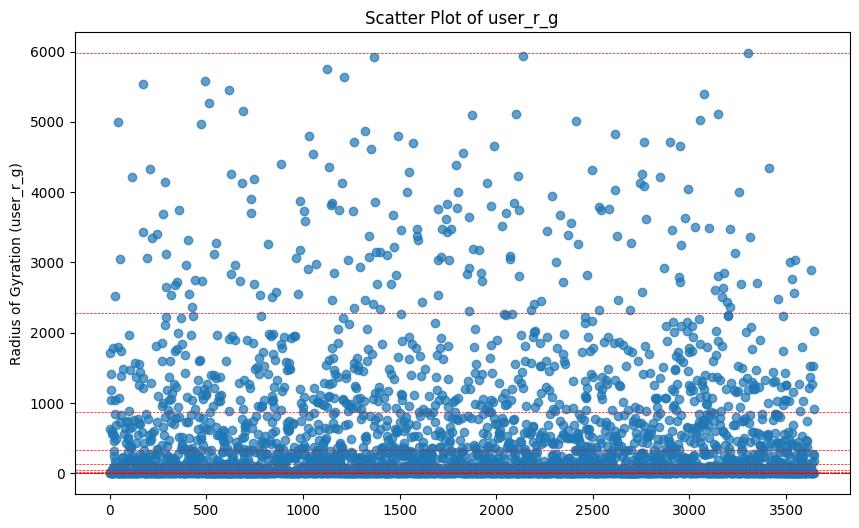

In [ ]:
bin_edges = np.logspace(np.log10(rgs.min()), np.log10(rgs.max()), num=20)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(rgs)), rgs, alpha=0.7,)
plt.ylabel('Radius of Gyration (user_r_g)')
plt.title('Scatter Plot of user_r_g')

for bin in bin_edges:
    plt.axhline(y=bin, color='r', linestyle='--', linewidth=0.5)

plt.show()

We see that unlike previously, the smaller $r_g$ values now seem most dense. Now, we see that looking at it this way, picking an interval randomly on the x-axis, the highest number of occurrences will be if the interval is as close to 0 as possible - regions get more sparse, and those $<10$ instances below 0.01 appear to be most dense. 

<br>While this mathematically makes sense, we'd have to remember that in practice this can actually be misleading for values of [$~10^{-5},10^{-2}$] - these are rare by nature and probably happen only to "human error" (e.g. logging in twice without moving a meter) - it just so happens that as these values are small, the differences between them are small and the bin widths are small.<br>
It's debatable if binning logarithmically in that region is correct. If the system for some reason has a bug, storing some very high values in the range of $[10^7+0.00001, 10^7+0.1]$, logarithmic binning would not highlight this patch of instances with a high probability as the bin would contain the empty region of $[10^6,10^7]$ too (or something similar). Is this "reasonable"? I'd say both patches should have the same amount of "probability" if they have the same occurrence - it just happens to be that the patch in our dataset is very close to 0. Probably a more proper binning is to bin this region as one, having a unique length (e.g. 0.1-0.0001), then binning everything else logarithmically. (It's often not a good thing to bin something that is not continuous with one universal binning scheme, rather have different binning schemes for separate regions).


Continuing this line of thought, how do these small $r_g$ bin heights follow a quite power-law like structure? Don't all these bins contain only 1 instance?

Yes - the normalization makes the bin heights appear to be power-law distributed.

This I actually would call unfair, at least for the lowest values of the distribution. The bins that just contain 1 instance will of course mathematically have a power-law-like distribution: the bin height will be 1/(bin width) and if the bin width grows as $10^k$, i.e. every consecutive bin is 10 times wider than the previous, the bin height be $10$ times smaller, which on a loglog plot will represent a line (with a slope of -1). This is a consequence of the binning! Let's see the 1-instance bin heights in our case:

In [128]:
bin_edges = np.logspace(np.log10(min(rgs)), np.log10(max(rgs)), num=20)
counts, _ = np.histogram(rgs, bins=bin_edges)
heights, _ = np.histogram(rgs, bins=bin_edges, density=True)

print("Counts:" , counts[:10], "...")
print("Heights:", heights[:4], "...")
print("Ratio of heights for the first 3 bins (each has one instance):\n", heights[1]/heights[0], "and", heights[2]/heights[1])

Counts: [ 1  1  1  5  0  3  5 13 37 98] ...
Heights: [2.40581635 0.92050622 0.35220133 0.67379107] ...
Ratio of heights for the first 3 bins (each has one instance):
 0.3826169955800181 and 0.3826169955800171


The ratio is not exactly 1, but something dependent on the number of bins, but we still can see the point. The first 3 bins contain 1 instance, and after normalization their height decreases with the same factor: 0.38261699... - of course that represents a power law! (If I'm right, with $\alpha = -log_{10}0.3826$). (I might have missed out on something as the alpha would be too low, but the heights decrease with a constant factor means a power-law distribution).<br>
We artificially turned the "start" of the distribution into power-law-like, just by normalizing.

<br> Moreover, normalizing impacts the power-law distribution in general.<br>
If on such a corrected-density plot we'd observe a power-law distribution by fitting a line perfectly, then that means that with a rough estimation (this is half-discrete half-continuous), $p(x,k) \propto 10^kx^{-\alpha}$ where $x$ is in the $k$ th bin, because the observed distribution $r(x) \propto x^{-\alpha}$ is power-law, and we get that by dividing $p(x,k)$ by the bin width, which grows 10-times in size for each consecutive bin. More properly, with bins starting from 1, $k=\lfloor log_{10}x\rfloor$.<br>
If we observe a power-law on this plot, underlying we have something that is not power-law distributed, because: $log(p(x,k)) = -\alpha log(x) + k$ and $$\frac{log(p(x,k))}{log(x)} = -\alpha + \frac{k}{log(x)}$$
the slope of the line is not constant - the underlying distribution decreases slower, moreover $\frac{k}{log(x)}=\frac{\lfloor log(x)\rfloor}{log(x)}$ is nearly 1, equals 1 when $x$ goes to infinity - which results in a quasi-power-law distribution, however with an exponent of $-\alpha+1$ instead.

<br> So when we use density normalization, and we see a line on the log-log plot - we should be careful, and only study scale-freeness on large $x$ values.


The $r_g$ values which are at least 1 kilometer:

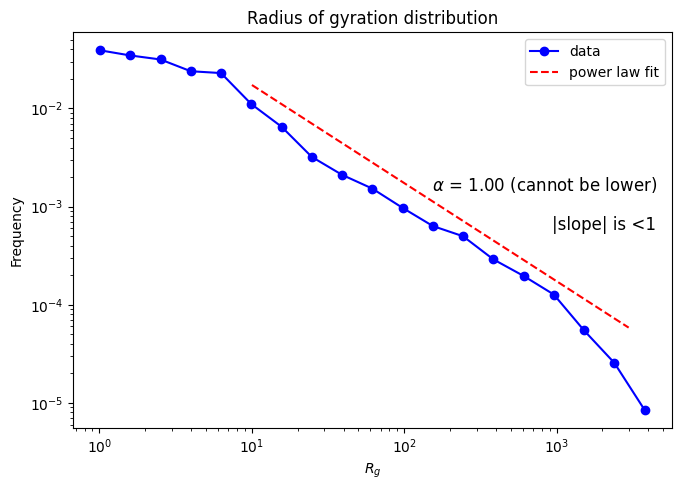

In [146]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
bin_edges = np.logspace(np.log10(min(rgs[rgs>1])), np.log10(max(rgs[rgs>1])), num=20)
density, _ = np.histogram(rgs, bins=bin_edges, density=True)

plt.loglog(bin_edges[:-1], density, marker='o', linestyle=None,  color='blue',label='data')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'$R_g$')

ax.set_title('Radius of gyration distribution')

fit = powerlaw.Fit(rgs, discrete=True, xmin=10,xmax=3000)
fit.power_law.plot_pdf(color='red', linestyle='--', ax=ax, label='power law fit')
plt.text(0.6, 0.6, r'$\alpha$ = %.2f (cannot be lower)' % fit.alpha, fontsize=12, transform=ax.transAxes)
plt.text(0.8, 0.5, r'|slope| is <1',fontsize=12, transform=ax.transAxes)

plt.legend()
plt.tight_layout()
plt.show()

In fact, since the slope is less than one from this plot (cannot fit a fit with $\alpha \leq 1$), the real underlying distribution in this range has a positive exponent i.e. is increasing - which is backed by our histogram from the non-normalized height section.